# scLVM  - Accounting for cell-to-cell heterogeneity in single-cell RNA-Seq data

scLVM requires preprocessed and normalize signle-cell RNA-Seq data as input. This example assumes that the data have already been processed appropriately. For an example of how the input file for this notebook can be generated form raw counts, see R/transform_counts_Tcells.R

## Stage 1: Fitting process

scLVM uses the Gaussian Process Latent variable model to fit a cell-cell covariance matrix, which is induced by a specified number of hidden factor (typically low rank). This approach resembles a Principal Component Analysis on genes annotated to a hidden factor (such as cell cycle). However, instead of explicitly reconstructing PCA loadings and scores, the GPLVM approach fits a low-rank cell-to-cell covariance to the empirical covariance matrix of these genes. Moreover, scLVM accounts for the technical noise estimates during the fitting.

In [51]:
# activiate inline plotting
%pylab inline
# load modules
import sys
import scipy as SP
import pylab as PL
from matplotlib import cm
import h5py
import os

#adjust path
scLVM_BASE = './..'
from scLVM import scLVM

#sys.path.append(scLVM_BASE)
#sys.path.append( scLVM_BASE +'..')
#sys.path.append(scLVM_BASE + 'scLVM/utils') #this is not included in the github repo
#sys.path.append(scLVM_BASE +'CFG')
#from misc import *
#from barplot import *
#from default import *
from scLVM.utils.barplot import *

from IPython.display import Latex

Populating the interactive namespace from numpy and matplotlib


First, the required data have to be loaded. These include:
* Normalised gene expression data: LogNcountsMmus
* Technical noise (in log space): LogVar_techMmus 
* Gene symbols: gene_names
* Heterogeneous genes (boolean vector): genes_geterogen 
* Cell cycle genes (vector of indices): cellcyclegenes_filter

In [6]:
data = os.path.join(scLVM_BASE,'data','Tcell','data_Tcells_normCounts.h5f')
f = h5py.File(data,'r')
Y = f['LogNcountsMmus'][:]                 # gene expression matrix
tech_noise = f['LogVar_techMmus'][:]       # technical noise
genes_het_bool=f['genes_heterogen'][:]     # index of heterogeneous genes
geneID = f['gene_names'][:]            # gene names
cellcyclegenes_filter = SP.unique(f['cellcyclegenes_filter'][:].ravel() -1) # idx of cell cycle genes from GO
cellcyclegenes_filterCB = f['ccCBall_gene_indices'][:].ravel() -1        # idx of cell cycle genes from cycle base ...

First, for the fitting process, we need the gene matrix of cell cycle genes:

In [7]:
# filter cell cycle genes
idx_cell_cycle = SP.union1d(cellcyclegenes_filter,cellcyclegenes_filterCB)
# determine non-zero counts
idx_nonzero = SP.nonzero((Y.mean(0)**2)>0)[0]
idx_cell_cycle_noise_filtered = SP.intersect1d(idx_cell_cycle,idx_nonzero)
# subset gene expression matrix
Ycc = Y[:,idx_cell_cycle_noise_filtered]

Visualize the cell cycle matrix

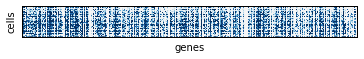

In [8]:
plt = PL.subplot(1,1,1)
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
#PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('genes')
PL.ylabel('cells')

scLVM can now be fit using the cell cycle expression matrix. The user needs to define the number of latent factors to be fitted. Initially, we fit a model assuming a large numbers of factos:

In [9]:
k = 80                    # number of latent factors
out_dir = scLVM_BASE + 'cache'       # folder where results are cached
file_name = 'Kcc.hdf5'    # name of the cache file
recalc = True             # recalculate X and Kconf
use_ard = True            # use automatic relevance detection
sclvm = scLVM(Y)
#Fit model with 80 factors
X_ARD,Kcc_ARD,varGPLVM_ARD = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=k,out_dir=out_dir,file_name=file_name,recalc=recalc, use_ard=use_ard)

In order to determine an appropriate number of hidden factors, it is instructive to visualize the variance contributions of the individual latent factors. 

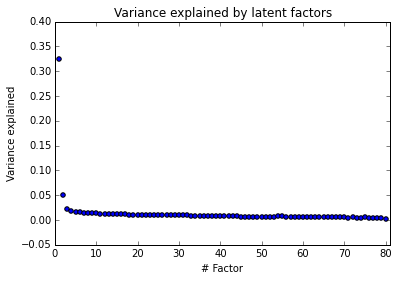

In [10]:
#Plot variance contributions from ARD 
plt = PL.subplot(1,1,1)
PL.title('Variance explained by latent factors')
PL.scatter(SP.arange(k)+1,varGPLVM_ARD['X_ARD'])
PL.xlim([0,k+1])
PL.xlabel('# Factor')
PL.ylabel('Variance explained')

In this example (and generally when considering cell cycle as the confounding factor), there is a large gap in the proportion of explained variance between the first and the second factor. This suggests, that a single latent factor underlies the variation captured by the cellcycle genes. Consequently, we choose to re-fit the scLVM mdoel with one latent factor only.

In [11]:
#Fit model with a single factor (rank 1 covariance matrix)
X,Kcc,varGPLVM = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=1,out_dir='./cache',file_name=file_name,recalc=True, use_ard=False)

The inferred cell to cell covaraince matrix can be visualized: 

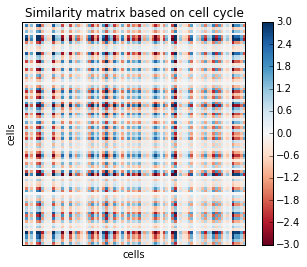

In [12]:
#Plot inferred similarity matrix
plt = PL.subplot(1,1,1)
PL.title('Similarity matrix based on cell cycle')
PL.imshow(Kcc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('cells')
PL.ylabel('cells')

## Stage 2: Variance decomposition and cell cycle correction

First, we use the fitted scLVM model to decompose the source of variance for each gene.

In [13]:
# considers only heterogeneous genes
Ihet = genes_het_bool==1
Y    = Y[:,Ihet]
tech_noise = tech_noise[Ihet]
geneID = geneID[Ihet]

The computation time for the next step can be substantial. If large datasets are considerd, it may be advisable to distribute these calculations on a high performance compute cluster. In this case i0 and i1 determine the range of genes for wich this anlaysis is performed. Here, we fit the model on 1,000 genes only in order to limit computation times. Consequently, all the downstram analyses illustrated in this notebook are done on a subset of all variable genes only.

In [14]:
#optionally: restrict range for the analysis
i0 = 0    # gene from which the analysis starts
i1 = 1000 # gene at which the analysis ends 

# construct sclvm object
sclvm = scLVM(Y,geneID=geneID,tech_noise=tech_noise)

# fit the model from i0 to i1
sclvm.varianceDecomposition(K=Kcc,i0=i0,i1=i1)


Once the contribution of cell cycle to the observed variance is estimated, cell-cycle corrected gene expression levels can be obtained. The variance component estimates calculated by scLVM are normalised such that they sum uo to 1. There may be a small number of genes where the maximum likelihood fit does not converge propperly. We suggest to remove these in downstream analyses.

In [15]:
normalize=True    # variance components are normalizaed to sum up to one

# get variance components
var, var_info = sclvm.getVarianceComponents(normalize=normalize)
var_filtered = var[var_info['conv']] # filter out genes for which vd has not converged

# get corrected expression levels
Ycorr = sclvm.getCorrectedExpression()
Ycorr.shape

(81, 100)

Here, we visualize the resulting variance component using a pie chart. Shown are the average contributions of variance (across genes) for different categories:
* Hidden_0: the first hidden factor, here the the cell cycle
* bio_noise: the residual biological variation
* techh_noise: the technical noise level

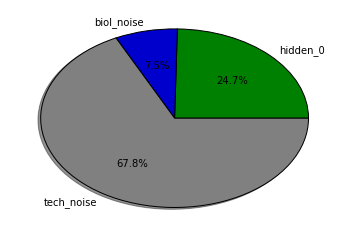

In [16]:
#calculate average variance components across all genes and visualize
var_mean = var_filtered.mean(0)
colors = ['Green','MediumBlue','Gray']
pp=PL.pie(var_mean,labels=var_info['col_header'],autopct='%1.1f%%',colors=colors,
       shadow=True, startangle=0)

We can also visualize this stratifying for different levels of technical noise.

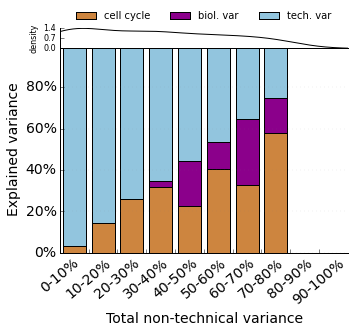

In [68]:
H2=1-var_filtered[:,2]
var_comp_fileds = SP.array([[0, 'cell cycle', 'Peru'],
       [1, 'biol. var', 'DarkMagenta'],
       [2, 'tech. var', '#92c5de']], dtype=object)
var_plot(var_filtered,H2,var_comp_fileds,normalize=True, figsize=[5,4])

## Gene correlation analysis

The fitted cell cycle covariance matrix can also be used in a range of other analyses. Here, we illustrate it's use to improve the estimation of pairwise correlation coefficients between genes, while accounting for the cell cycle.
For each gene i, we fit a linear mixed model with a fixed effect representing the contribution of a second gene j and random effect representing the contribution of the cell cycle. Gene correlations can then be determined by testing the significance of the fixed effect. Again, the computational complexity of this analysis can be substantial, requiring distributing these analyses on a parallel compute cluster. For illustration, we here consider the gene-gene correlation network of the first 10 genes.

In [18]:
i0 = 0     # gene from which the analysis starts
i1 = 10    # gene to which the analysis ends

# fit lmm without correction
pv0,beta0,info0 = sclvm.fitLMM(K=None,i0=i0,i1=i1,verbose=False)
# fit lmm with correction
pv1,beta1,info1 = sclvm.fitLMM(K=Kcc,i0=i0,i1=i1,verbose=False)

(<matplotlib.text.Text at 0x11e16b810>, <matplotlib.text.Text at 0x11e195a50>)

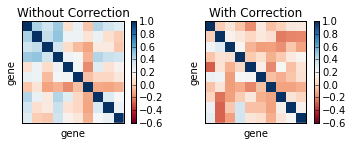

In [19]:
plt=PL.subplot(2,2,1)
PL.title('Without Correction')
p=PL.imshow(beta0[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')
plt=PL.subplot(2,2,2)
PL.title('With Correction')
p=PL.imshow(beta1[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')

## Downstream analysis

The cell-cycle corrected gene expression matix can used for various kinds of downstream analysis. This includes clustering, visualisation, network analysis etc. To use the correct expression matrix in other programmes, it is straightforward to export the corrected expression matrix as CSV file:

In [20]:
SP.savetxt('Ycorr.txt',Ycorr)

As an example for downstream analyses using corrected exprssion levels, we here consider GPy to fit a non-linear Bayeisan PCA model, therbey visualizing hidden substructures between cells.

In [21]:
import GPy

warning in stationary: failed to import cython module: falling back to numpy


In [22]:
# Model optimization
Ystd = Ycorr-Ycorr.mean(0)
Ystd/=Ystd.std(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=0, max_iters=2000)


The model assumes two principle components. Here, we visualize the relative importance of the two components.

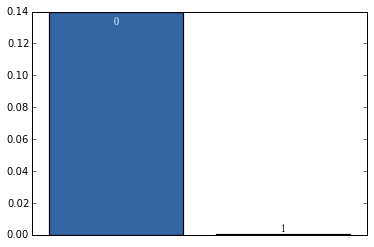

In [23]:
m.kern.plot_ARD()

Finally, the position of individual cells in the principal component space can be visualized. Cells are colour coded by GATA3 expression, a canonical T-cell differentiation marker gene.

<matplotlib.colorbar.Colorbar instance at 0x11975a710>

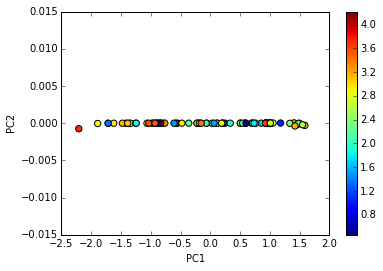

In [42]:
i_Gata3 = SP.where(geneID=='ENSMUSG00000015619')
#color = Ycorr[:,i_Gata3]
color = Ycorr[:,0]
PL.scatter(m.X[:,0]['mean'], m.X[:,1]['mean'], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

We comapre the non-linear projection to a standard principle component anlaysis: